# In-Python Usage

Here we discuss the usage and some of the optional arguments of `maskfill`. 



In [1]:
from maskfill import maskfill 
import time

We'll begin by loading the uncorrupted and corrupted versions of the m51 example presented in `van Dokkum & Pasha (2024)`. One can run maskfill simply by passing strings to the path of relevant files, but for this example we will read them in as python arrays so we can visualize the inputs as well. 

In [2]:
from astropy.io import fits 
image_clean = fits.getdata('../example_m51/m51_org.fits')
image_cr = fits.getdata('../example_m51/m51_with_cosmicrays.fits')
mask = fits.getdata('../example_m51/m51_mask.fits')

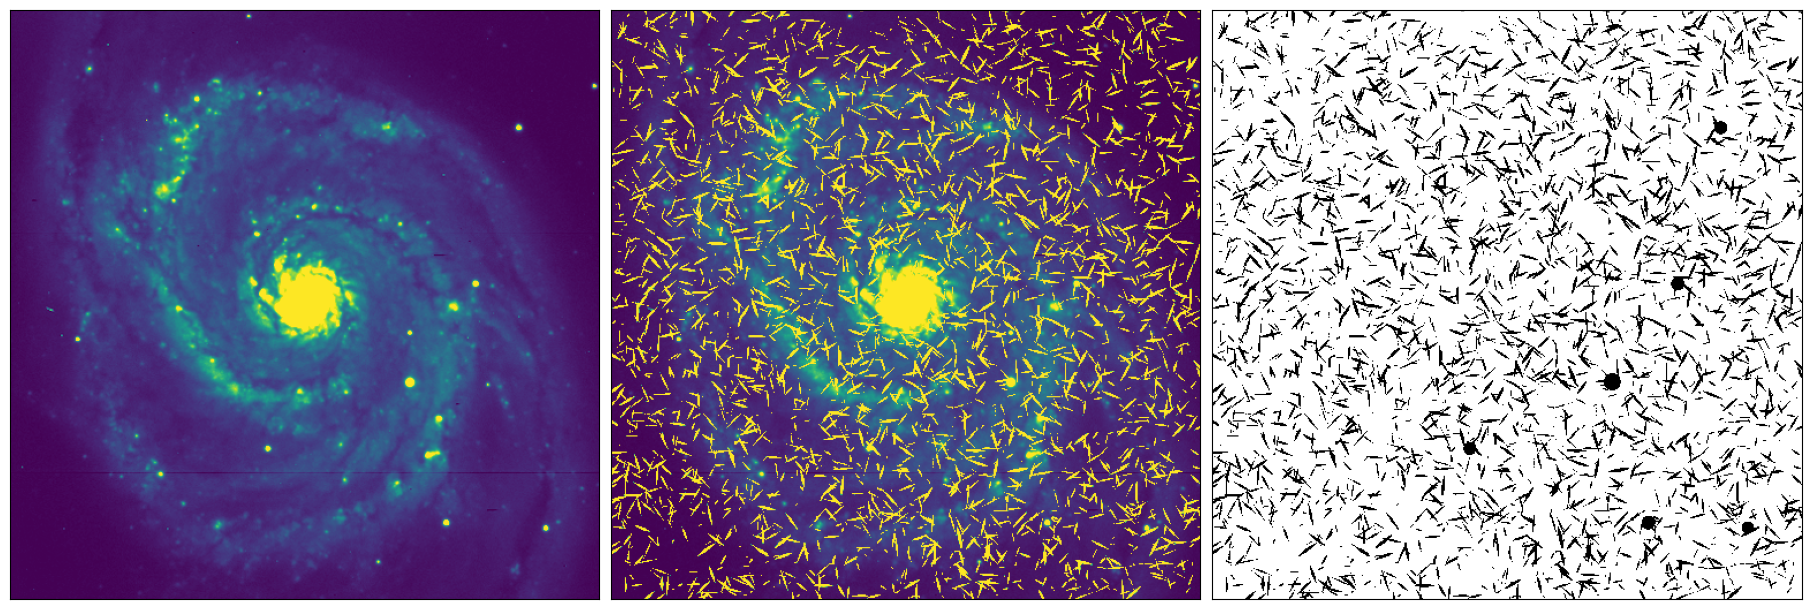

In [3]:
import matplotlib.pyplot as plt 
import numpy as np 
fig, ax = plt.subplots(1,3,figsize=(18,59),constrained_layout=True)
vmin,vmax=np.percentile(image_clean,[1,99])
ax[0].imshow(image_clean,origin='lower',vmin=vmin,vmax=vmax)
ax[1].imshow(image_cr,origin='lower',vmin=vmin,vmax=vmax)
ax[2].imshow(mask,origin='lower',vmin=0.1,vmax=0.9,cmap='gray_r')
for i in ax:
    i.set_xticks([])
    i.set_yticks([])

## Simple run 
Let's begin with an option-free run. We will simply feed the corrupted image and mask to `maskfill`. I will keep both of the outputs here for examination.

In [4]:
start = time.time()
mfill_smooth, mfill = maskfill(image_cr,mask)
total_time = time.time()-start
print(f'time taken: {total_time:.2f} s')

time taken: 2.27 s


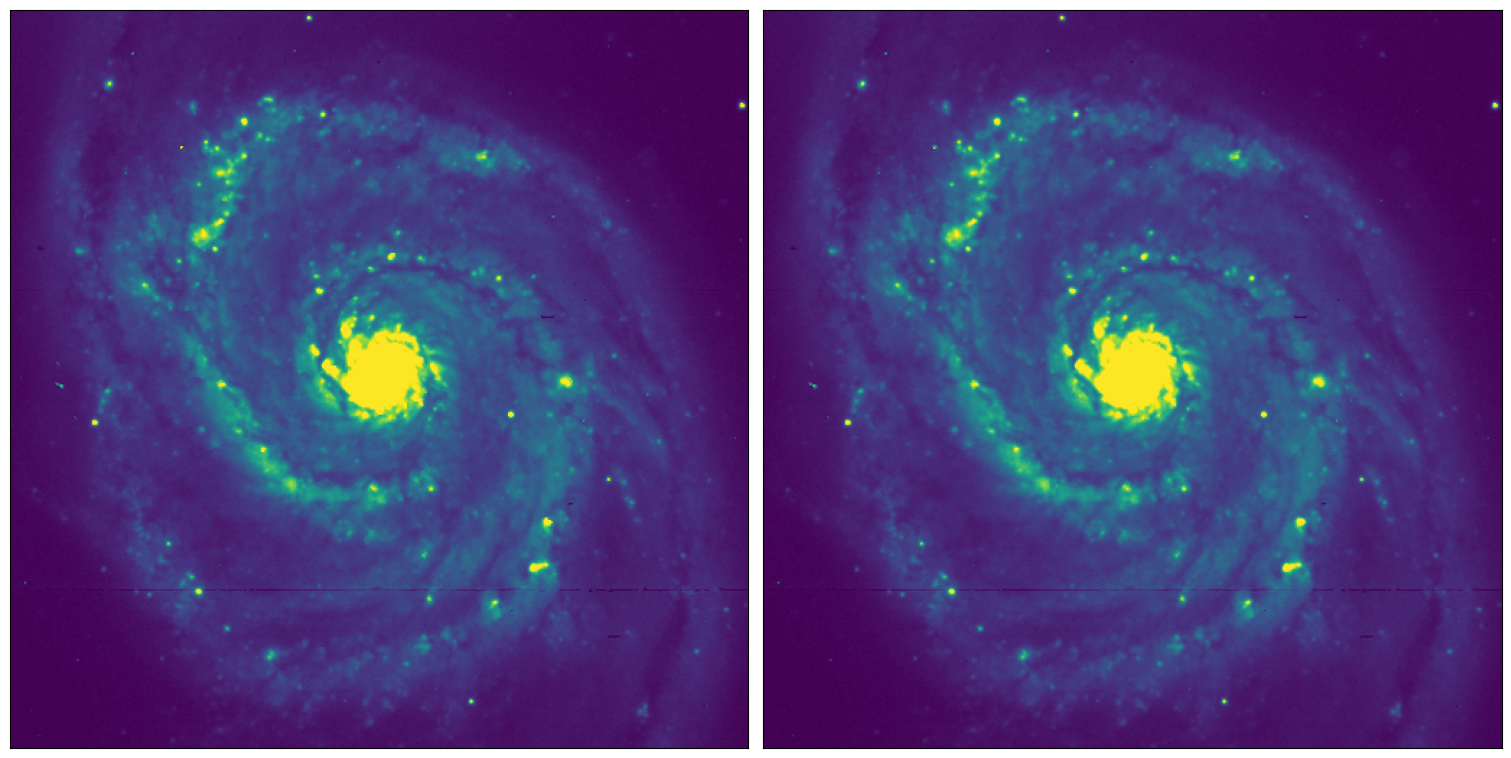

In [5]:
fig, ax = plt.subplots(1,2,figsize=(15,7.5),constrained_layout=True)
ax[0].imshow(mfill,origin='lower',vmin=vmin,vmax=vmax)
ax[1].imshow(mfill_smooth,origin='lower',vmin=vmin,vmax=vmax)
for i in ax:
    i.set_xticks([])
    i.set_yticks([])

At the scale of the full image, it is difficult to tell the difference between the smoothed and unsmoothed output; both have done a good job infilling the masked regions. 

We can zoom in to a spot where a star was infilled to tell the difference better:

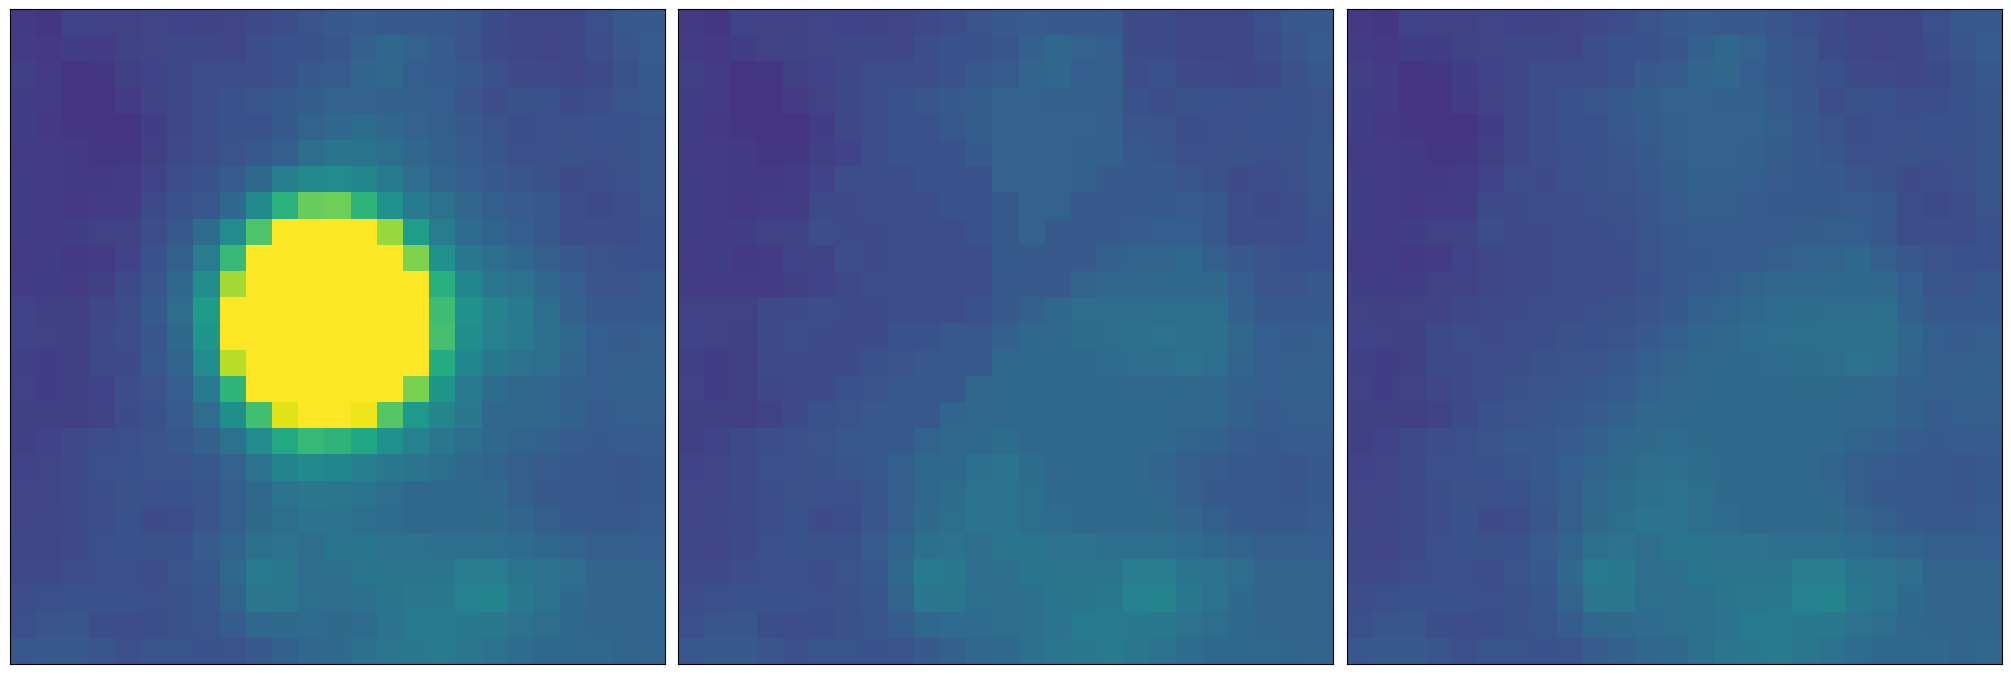

In [6]:
zoom_nosmooth = mfill[175:200,335:360]
zoom_smooth = mfill_smooth[175:200,335:360]
orig = image_clean[175:200,335:360]
fig, ax = plt.subplots(1,3,figsize=(20,7.5),constrained_layout=True)
ax[0].imshow(orig,origin='lower',vmin=vmin,vmax=vmax)
ax[1].imshow(zoom_nosmooth,origin='lower',vmin=vmin,vmax=vmax)
ax[2].imshow(zoom_smooth,origin='lower',vmin=vmin,vmax=vmax)
for i in ax:
    i.set_xticks([])
    i.set_yticks([])

As we can see, the unsmoothed maskfill output has a bit of a sharper structure in the infilled region, which the smoothed version has reduced. 

## Optional Arguments 

We now discuss in a bit more detail the optional arguments in `maskfill`. 

### Window Size
The argument which you are most likely going to need to change (particularly for large masks, or masks which have not been grown large enough to cover *all* the light of features being blocked) is the window size, using the `size` keyword. This argument controls the window of adjacent pixels used for computation of the local medians, and for the final smoothing step. 

The `size` keyword must be odd, so if you find that a size-3 kernel (default) is "overfitting" your data, you can try increasing the `size` to larger odd numbers, e.g., 5, 9, 11. 

Here we will demonstrate this in action by creating an (arbitrary) large mask on a cutout from the m51 image. 

In [7]:
def indices_within_distance(array, x, y, distance):
    rows, cols = np.indices(array.shape)
    distances = np.sqrt((rows - x)**2 + (cols - y)**2)
    indices = np.where(distances <= distance)
    return indices

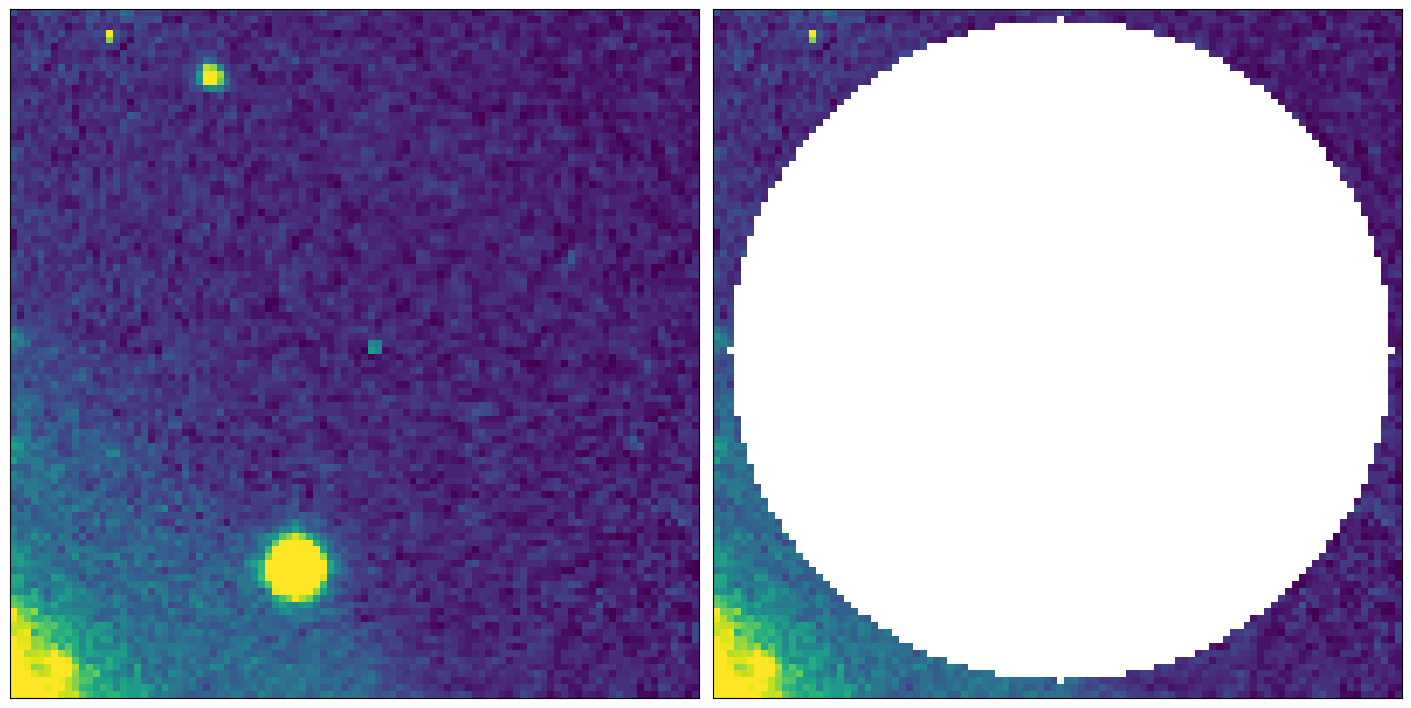

In [8]:

image_cutout  = image_clean[390:490,400:500]
cutout_mask = np.zeros(image_cutout.shape)
cutout_mask[indices_within_distance(image_cutout,50,50,48)] = 1
fig, ax = plt.subplots(1,2,figsize=(14,7.5),constrained_layout=True)
vmin,vmax=np.percentile(image_cutout,[1,99])
ax[0].imshow(image_cutout,origin='lower',vmin=vmin,vmax=vmax)
ax[1].imshow(np.ma.masked_array(image_cutout,mask=cutout_mask.astype(bool)),origin='lower',vmin=vmin,vmax=vmax)
#ax[2].imshow(zoom_smooth,origin='lower',vmin=vmin,vmax=vmax)
for i in ax:
    i.set_xticks([])
    i.set_yticks([])

In [9]:
fill1, _ = maskfill(image_cutout,cutout_mask)
fill2, _ = maskfill(image_cutout,cutout_mask,size=5)
fill3, _ = maskfill(image_cutout,cutout_mask,size=11)

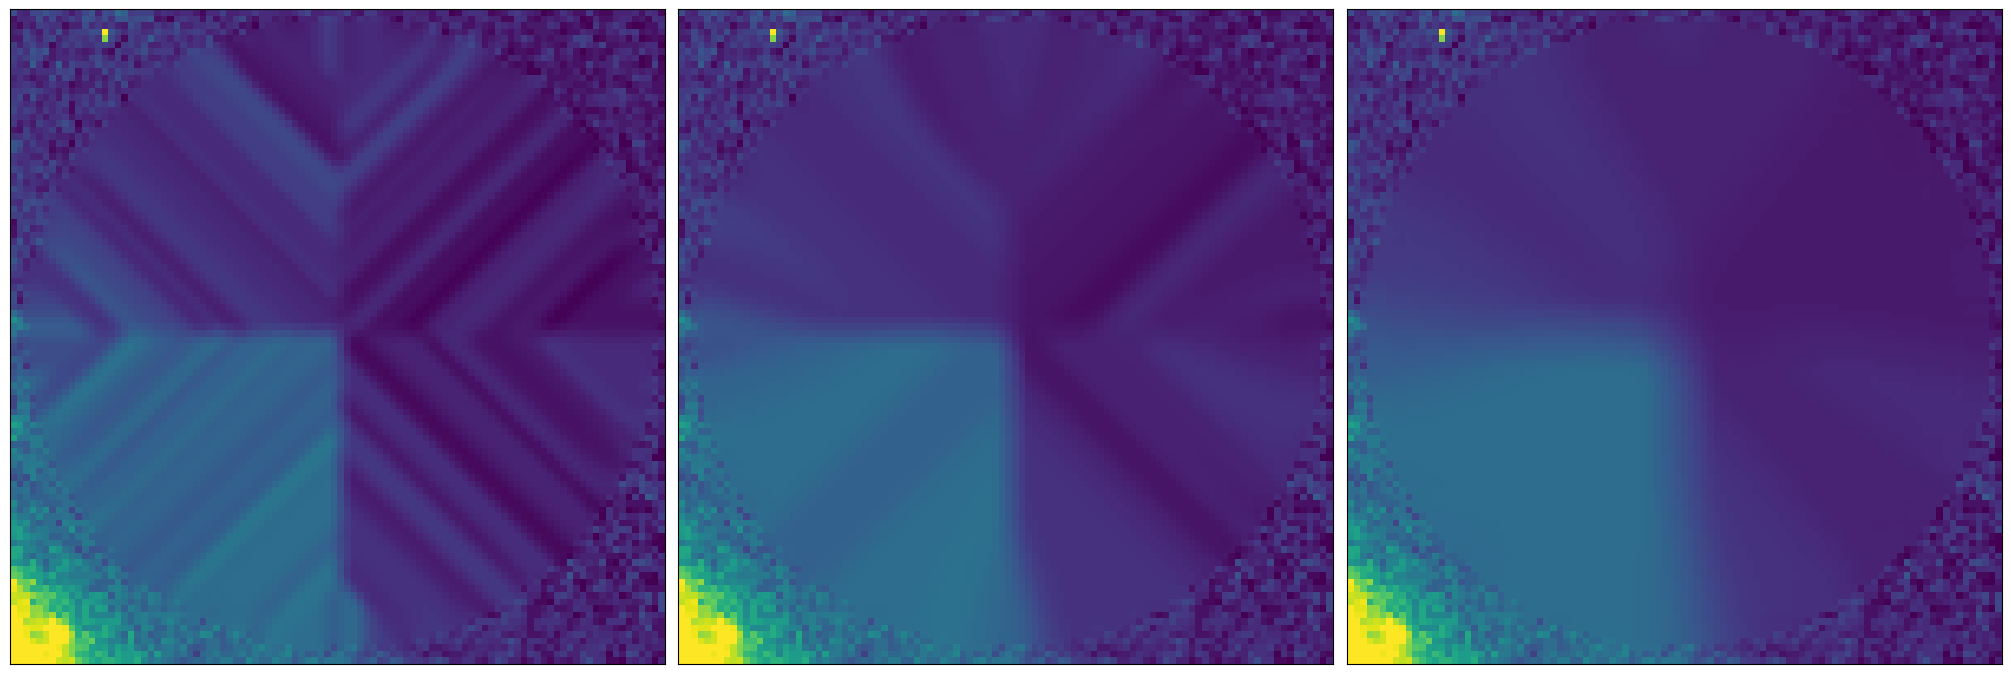

In [10]:
fig, ax = plt.subplots(1,3,figsize=(20,7.5),constrained_layout=True)

ax[0].imshow(fill1,origin='lower',vmin=vmin,vmax=vmax)
ax[1].imshow(fill2,origin='lower',vmin=vmin,vmax=vmax)
ax[2].imshow(fill3,origin='lower',vmin=vmin,vmax=vmax)
#ax[2].imshow(zoom_smooth,origin='lower',vmin=vmin,vmax=vmax)
for i in ax:
    i.set_xticks([])
    i.set_yticks([])

Depending on the size of your masks or some features in your image, you may find increasing the `size` parameter improves results, For masks that are smaller than ~10s of pixels, a 3x3 mask will almost always be the most accurate and effective. 

### Intermediate Outputs 

If you want to visualize the infilling process, you can optionally choose to write the iterative steps of the algorithm by setting `writesteps=True`. This will save `fits` files to the current working directory of the format `_iter_1.fits` `_iter_2.fits`, etc. 


In [11]:
fill2, _ = maskfill(image_cutout,cutout_mask,size=5,writesteps=True)

Let's read in and visualize the files just created:

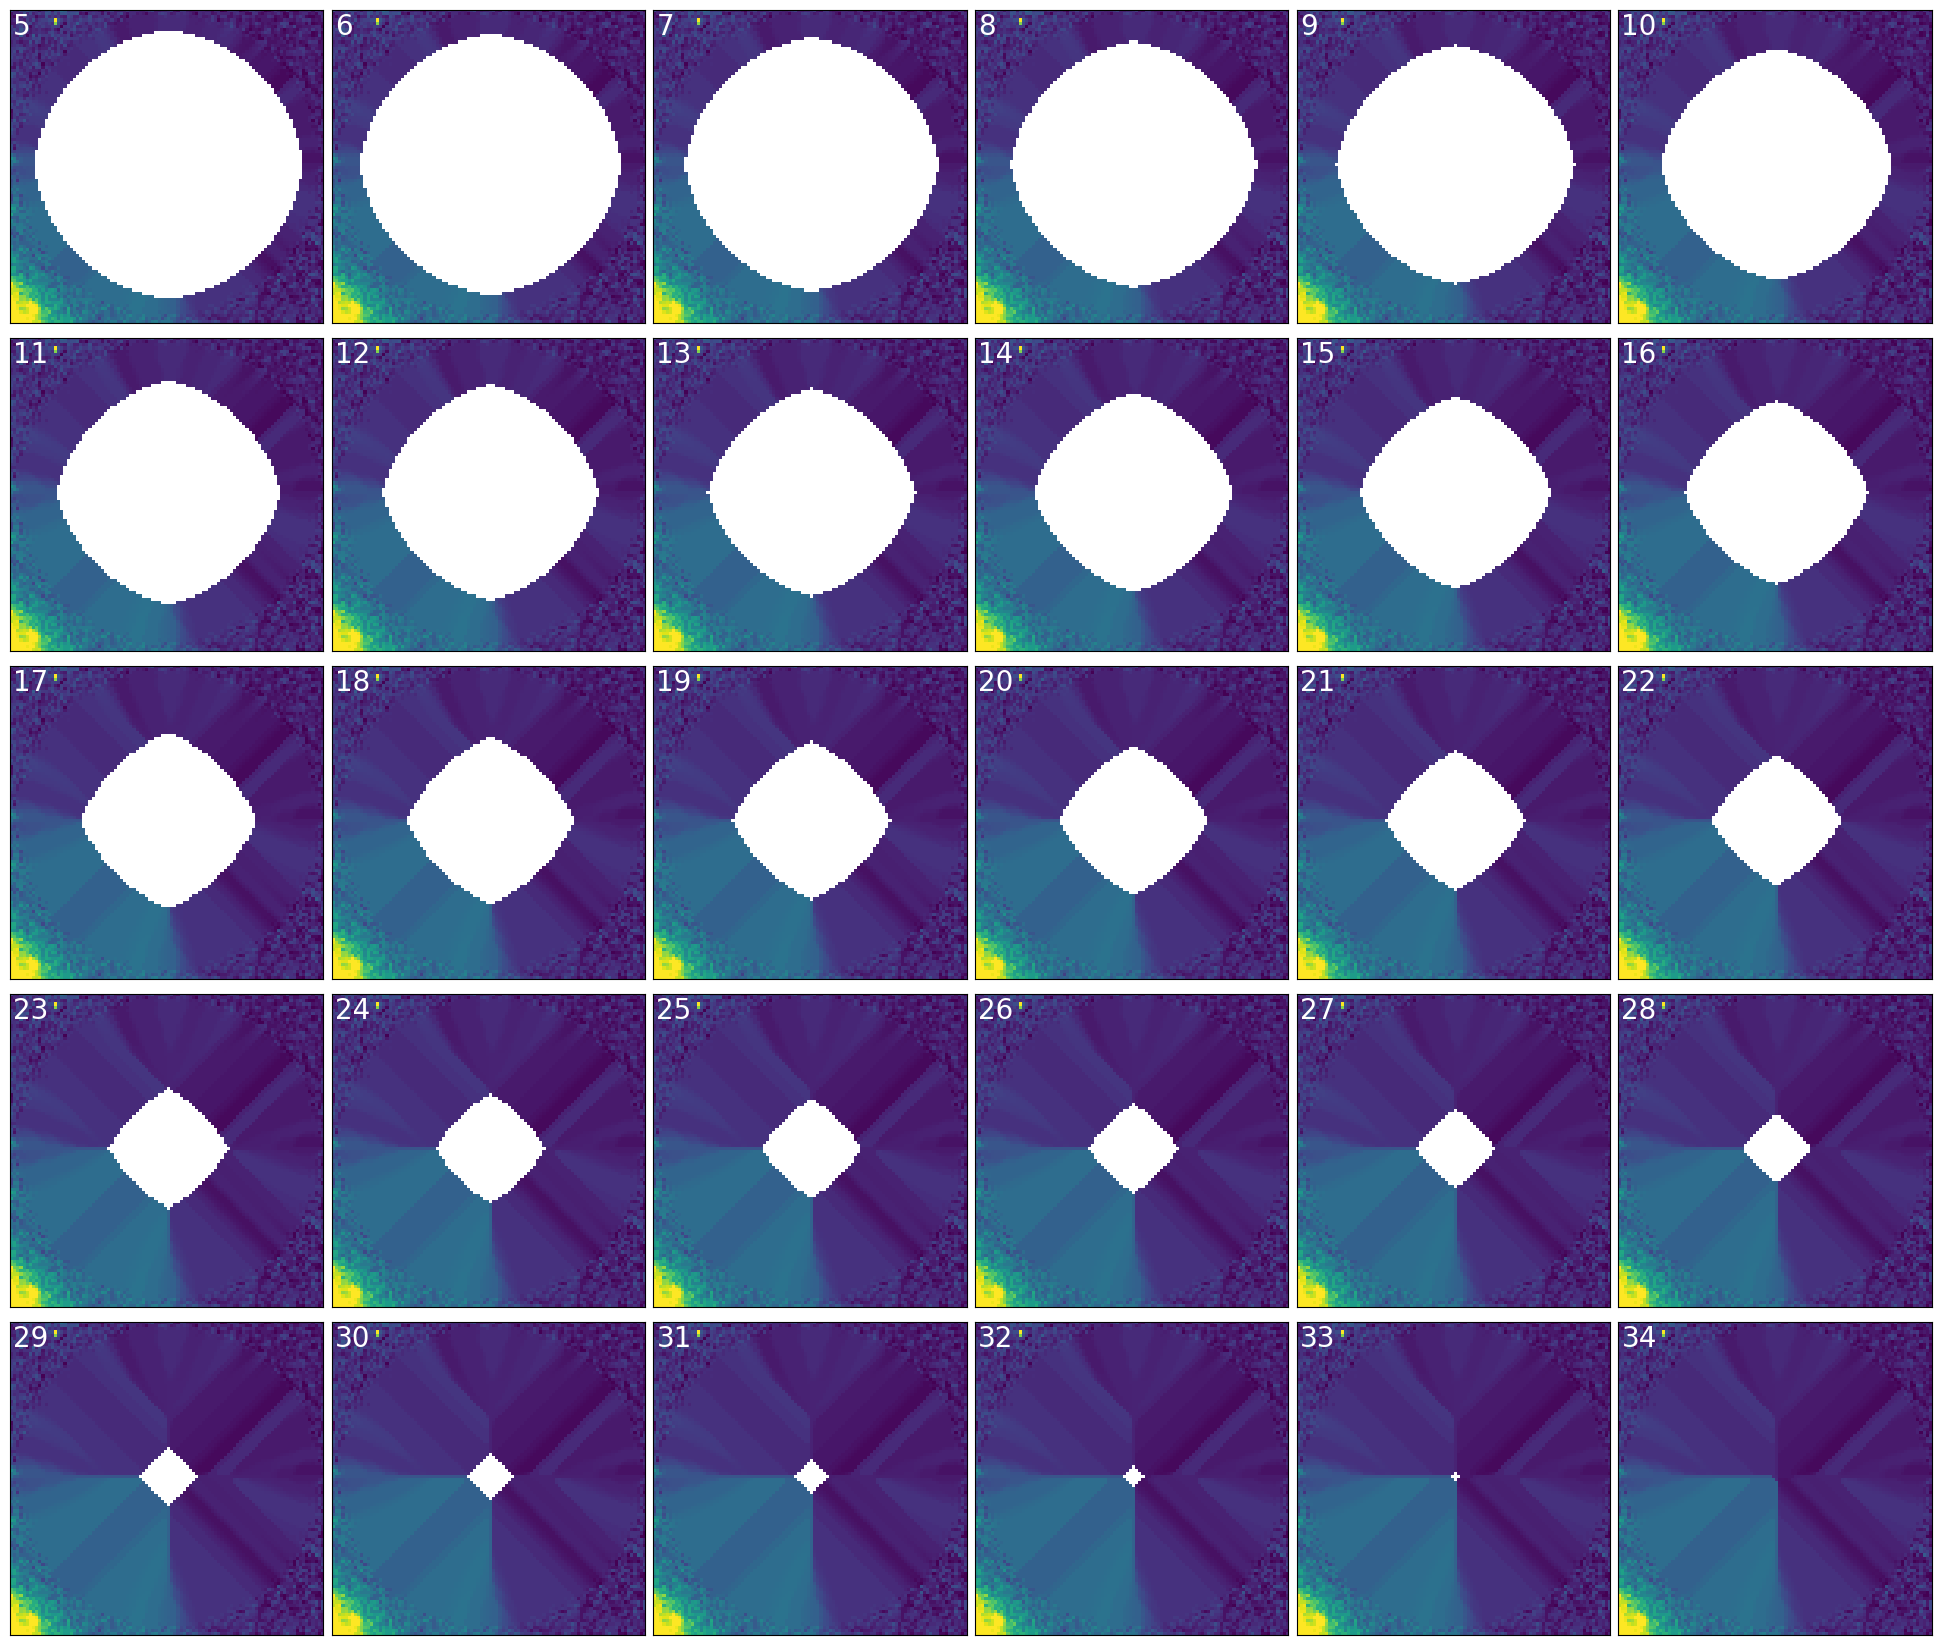

In [12]:
fig,ax=plt.subplots(5,6,figsize=(19.3,16.4),constrained_layout=True)
ax = ax.flatten() 
for n,i in enumerate(ax):
    n+=5 # skip the first 3 because we have 34 outputs, which isn't nicely square
    _tmp = fits.getdata(f'_iter_{n}.fits')
    i.imshow(_tmp,origin='lower',vmin=vmin,vmax=vmax)
    i.text(0.01,0.99,str(n),color='w',va='top',transform=i.transAxes,fontsize=20)
    i.set_xticks([])
    i.set_yticks([])

### Writing to file 

From within Python, `maskfill` will always returned the filled arrays directly. However, if you would also like to save a `fits` file at the end of the run, you can do so via the `output_file` argument, where you can provide a file path / file name. 

Note that when smoothing is enabled (see below), that image will be in the 0th extension, and the pre-smoothed version will be placed in the first extension. If smoothing is disabled, the 0th extension will have the pre-smoothed version (with nothing in additional extensions). The behavior from the command line is the same; you always provide an output file and the extensions are filled depending on whether smoothing is enabled. 

### Smoothing 

Smoothing is an optional step at the end of the `maskfill` algorithm. Because the unsmoothed version is always created, we don't abandon it. When you run with smoothing on (default), the outputs are of the form 

```
smoothed, unsmoothed = maskfill(...)
```

while if you choose to use the `smooth=False` argument, the outputs will be 

```
unsmoothed, None = maskfill(...)
```

As mentioned above, if you write to a file while smoothing, the pre-smoothed version is still accessible in the 1st extension of the output file. 



### Operator Selection 

The `operator` argument determines whether the algorithm uses a median or a mean during infilling. We recommend median filling most of the time. 

### Extension Selection 

If your images (and masks) are stored in a different extension of their fits files than 0th (when loading from fits), you can optionally pass the `extension` argument to specify which extension contains the data. At the moment, both the image and mask must be in the same extension number of their respective files. 